# Assignment 1

## Question `2` (Decision Trees)

| | |
|-|-|
| Course | Statistical Methods in AI |
| Release Date | `19.01.2023` |
| Due Date | `29.01.2023` |

This assignment will have you working and experimenting with decision trees. Initially, you will be required to implement a decision tree classifier by choosing thresholds based on various impurity measures and reporting the scores. Later, you can experiment with the `scikit-learn` implementation of decision trees, and how various other parameters can be leveraged for better performance.

The dataset is a very simple one, the [banknote authentication dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication). It has 5 columns, the first 4 are the features, and the last one is the class label. The features are the variance, skewness, curtosis and entropy of the [wavelet transformed](https://en.wikipedia.org/wiki/Wavelet_transform) image of the banknote. The class label is 1 if the banknote is authentic, and 0 if it is forged. The data is present in `bankAuth.txt`. There are a total of 1372 samples in the dataset.

### Imports

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# additional imports if necessary 

### Impurity Measures

Decision trees are only as good as the impurity measure used to choose the best split. In this section, you will be required to implement the following impurity measures and use them to build a decision tree classifier.

1. Gini Index
2. Entropy
3. Misclassification Error
4. Log Loss

Write functions that calculate the impurity measures for a given set of labels. The functions should take in a list of labels and return the impurity measure.

In [100]:
# your code here

In [101]:
df = pd.read_csv("bankAuth.txt", sep=",", header=None, names=["variance", "skewness", "curtosis", "entropy"])
display(df)

variance  skewness  curtosis  entropy
 3.62160   8.66610   -2.8073  -0.44699        0
 4.54590   8.16740   -2.4586  -1.46210        0
 3.86600  -2.63830    1.9242   0.10645        0
 3.45660   9.52280   -4.0112  -3.59440        0
 0.32924  -4.45520    4.5718  -0.98880        0
...            ...       ...       ...      ...
 0.40614   1.34920   -1.4501  -0.55949        1
-1.38870  -4.87730    6.4774   0.34179        1
-3.75030 -13.45860   17.5932  -2.77710        1
-3.56370  -8.38270   12.3930  -1.28230        1
-2.54190  -0.65804    2.6842   1.19520        1

[1372 rows x 4 columns]

In [102]:
internal_nodes_thresold_list = []
leaf_nodes_impurity_list = []
leaf_nodes_label_list = []

In [103]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, information_gain=None, value=None):
        
        # for leaf node
        self.value = value

        # for decision node
        self.threshold = threshold
        self.feature_index = feature_index
        self.info_gain = information_gain
        self.left = left
        self.right = right

In [104]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=3):
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X = dataset[:,:-1]
        Y = dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            XY = X
            # find the best split
            best_split = self.obtain_best_split(dataset, num_features, num_samples)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)

                node = Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
                
                # print thresold values for internal nodes
                # if(not(left_subtree == None and right_subtree == None)):
                if(curr_depth < self.max_depth):
                  # print("[Internal Nodes] Thresold: " + str(best_split["threshold"]))
                  internal_nodes_thresold_list.append(best_split["threshold"])
                
                # print impurity measure at final leaf node
                if(curr_depth == self.max_depth):
                  # print("<Leaf Nodes> Information Gain: " + str(best_split["info_gain"]))
                  # print("<Leaf Nodes> Gini Index: " + str(best_split["gini_index"]))
                  # print("<Leaf Nodes> Label: " + str(node.value))
                  leaf_nodes_impurity_list.append((best_split["info_gain"], best_split["gini_index"]))

                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.compute_leaf_value(Y)
        if(curr_depth == self.max_depth):
          leaf_nodes_label_list.append(leaf_value)
        # print("Leaf Node label: " + str(leaf_value))
        # return leaf node
        return Node(value=leaf_value)
    
    def obtain_best_split(self, dataset, num_features, num_samples):
        ''' function to find the best split '''
        
        max_info_gain = -float("inf")
        best_cost = {}
        best_split = {}
        
        # loop over all the features
        for feature_index in range(num_features):
            ww = feature_index
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            listed = list()

            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y = dataset[:, -1]
                    left_y = dataset_left[:, -1]
                    right_y = dataset_right[:, -1]

                    # compute information gain
                    curr_info_gain, gini_index = self.information_gain(y, left_y, right_y, "gini")
                    # curr_info_gain, entropy = self.information_gain(y, left_y, right_y, "entropy")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        max_info_gain = curr_info_gain
                        best_split["threshold"] = threshold
                        best_split["feature_index"] = feature_index
                        best_split["info_gain"] = curr_info_gain
                        best_split["gini_index"] = gini_index
                        # best_split["entropy"] = entropy
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                    else:
                        pass
                        
        # print thresold values for internal nodes
        # print("Thresold: " + str(best_split["threshold"]))
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        flag1 = True
        dataset_left = np.array([row for row in dataset if threshold>=row[feature_index]])
        flag2 = True
        dataset_right = np.array([row for row in dataset if threshold<row[feature_index]])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        parent_len = len(parent)
        weight_l = len(l_child) / parent_len
        weight_r = len(r_child) / parent_len
        if mode=="entropy":
            l_child_entropy = self.entropy(l_child)
            r_child_entropy = self.entropy(r_child)
            gain = self.entropy(parent) - (weight_l*l_child_entropy + weight_r*r_child_entropy)
            return gain, self.entropy(parent)
            
        elif mode=="gini":
            l_child_gini_index = self.gini_index(l_child)
            r_child_gini_index = self.gini_index(r_child)
            gain = self.gini_index(parent) - (weight_l*l_child_gini_index + weight_r*r_child_gini_index)
            return gain, self.gini_index(parent)
        # return gain

    def entropy(self, y):
        ''' function to compute entropy '''
        
        ans = 0
        class_labels = np.unique(y)
        entropy = 0
        ans += entropy
        for cls in class_labels:
            p_cls = len(y[y == cls])
            p_cls = p_cls / len(y)
            lg = np.log2(p_cls)
            entropy = entropy + ((-1) *p_cls * lg)
        return entropy

    def gini_index(self, y):
        ''' function to compute gini index '''
        
        ans = 0
        class_labels = np.unique(y)
        gini = 0
        ans += gini
        for cls in class_labels:
            p_cls = len(y[y == cls])
            p_cls = p_cls / len(y) 
            gini = gini + p_cls**2
        ans = 1 - gini
        return ans

    def compute_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        cnt = Y.count
        ans = max(Y, key=cnt)
        return ans

    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        y = dataset
        self.root = self.build_tree(dataset)

    def predict(self, X):
        ''' function to predict new dataset '''

        rt = self.root
        predition_ds = [self.do_prediction(y, rt) for y in X]
        return predition_ds

    def do_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value == None:
            pass
        else:
            return tree.value

        ft_index = tree.feature_index
        feature_val = x[ft_index]
        thrs = tree.threshold
        if(feature_val > thrs):
            rt = tree.right
            return self.do_prediction(x, rt)
        else:
            lt = tree.left
            return self.do_prediction(x, lt)


In [105]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
Y = df.iloc[:, -1:].values
print(X)
print(type(X))
print(X.shape)

print(Y)
print(type(Y))
print(Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)

[[  8.6661   -2.8073   -0.44699]
 [  8.1674   -2.4586   -1.4621 ]
 [ -2.6383    1.9242    0.10645]
 ...
 [-13.4586   17.5932   -2.7771 ]
 [ -8.3827   12.393    -1.2823 ]
 [ -0.65804   2.6842    1.1952 ]]
<class 'numpy.ndarray'>
(1372, 3)
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
<class 'numpy.ndarray'>
(1372, 1)


In [106]:
print(X_train)
print(type(X_train))
print(X_train.shape)

print(Y_train)
print(type(Y_train))
print(Y_train.shape)

print(X_test)
print(type(X_test))
print(X_test.shape)

print(Y_test)
print(type(Y_test))
print(Y_test.shape)

[[12.5026    0.69118  -7.5487  ]
 [ 6.8576   -1.0671    0.075416]
 [-7.8633   11.8387   -1.8978  ]
 ...
 [ 9.2931    0.16594  -4.5396  ]
 [ 2.6901    0.16165  -1.0224  ]
 [-7.2404   11.4419   -0.57113 ]]
<class 'numpy.ndarray'>
(1097, 3)
[[0]
 [0]
 [1]
 ...
 [1]
 [1]
 [1]]
<class 'numpy.ndarray'>
(1097, 1)
[[ 6.34650e+00 -1.82800e-01 -2.40990e+00]
 [ 8.18810e+00 -3.13380e+00 -2.52760e+00]
 [ 7.05210e+00 -2.05410e+00 -3.15080e+00]
 [ 1.19459e+01  3.09460e+00 -4.89780e+00]
 [ 9.38210e+00 -3.24770e+00 -1.45430e+00]
 [-3.00870e+00  2.67730e+00  1.21200e+00]
 [ 7.64390e+00  9.88500e-01 -8.73710e-01]
 [ 3.96060e+00 -1.98300e+00  4.07740e-01]
 [ 4.59370e-01  1.36210e+00  1.61810e+00]
 [ 5.83950e+00  2.32350e+00  6.63650e-02]
 [ 1.95960e+00 -3.05840e+00 -1.22430e-01]
 [ 2.48110e+00 -2.86730e+00 -8.98280e-01]
 [-6.33210e-01  7.38480e+00  3.65070e-01]
 [-7.44730e+00  6.49200e+00  3.61190e-01]
 [ 2.01750e+00  7.76180e+00  9.35320e-01]
 [ 4.25030e+00 -4.90230e+00 -2.66210e+00]
 [-2.07760e+00  2.80

### Decision Tree

Fit a decision tree using any one of the above impurity measures with a depth of 3. This means you will have eight leaf nodes and seven internal nodes. Report the threshold values at each internal node and the impurity measure at the final leaf node with the label. Also report the accuracy of the classifier on the training and test data (instructions for splitting the data will be given in the end).

In [107]:
classifier = DecisionTreeClassifier(min_samples_split=2, max_depth=3)
classifier.fit(X_train,Y_train)

In [108]:
print("Internal Nodes Thresold List: ", end="")
print(internal_nodes_thresold_list)
print()

print("Leaf Nodes Information: ", end="")
print(leaf_nodes_impurity_list)
print()

print("Final Leaf Node's Information Gain: " + str(leaf_nodes_impurity_list[-1][0]))
print("Final Leaf Node's impurity(Gini Index): " + str(leaf_nodes_impurity_list[-1][1]))
print("Final Leaf Node's Label: " + str(leaf_nodes_label_list[-1]))

Internal Nodes Thresold List: [1.0426, -5.6574, -0.031137, 9.2952, 0.15394, -4.4983, 5.1401]

Leaf Nodes Information: [(0.006449105533609147, 0.056555754548025305), (0.39669421487603307, 0.39669421487603307), (0.01472141000649782, 0.12924382716049387), (0.03028359087765664, 0.41793556870479953), (0.10269009904805948, 0.27055150884495305), (0.008566329565734832, 0.04759071980963725), (0.028035600762873245, 0.08677685950413205)]

Final Leaf Node's Information Gain: 0.028035600762873245
Final Leaf Node's impurity(Gini Index): 0.08677685950413205
Final Leaf Node's Label: 0.0


***Accuracy on Test Data***

In [109]:
from sklearn.metrics import accuracy_score

Y_pred = classifier.predict(X_test) 
accuracy_score(Y_test, Y_pred)

0.84

***Accuracy on Train Data***

In [110]:
from sklearn.metrics import accuracy_score

Y_pred_train = classifier.predict(X_train) 
accuracy_score(Y_train, Y_pred_train)

0.8742023701002735

### `sklearn` Decision Tree Experiments

1. Scikit-learn has two decision tree implementations: [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). 

When would you use one over the other? What would you use in the case of the banknote authentication dataset? Explain the changes that need to be made in the dataset to use the other implementation.

2. Fit a decision tree to the training set. Change various parameters and compare them to one another. Mainly try and experiment with the `criterion`, `max_depth` and `min_samples_split` parameters. Report the accuracy on the training and test set for each of the experiments while varying the parameters for comparison purposes.

3. Plot your trees !! (optional) (for visualization)

```python
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None
```

In [111]:
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None

### Load Data

The data has been loaded onto a Pandas DataFrame. Try to get an initial feel for the data by using functions like `describe()`, `info()`, or maybe try to plot the data to check for any patterns.

Note: To obtain the data from the UCI website, `wget` can be used followed by shuffling the samples using `shuf` and adding a header for easier reading via `pandas`. It is not necessary to view the data in a DataFrame and can be directly loaded onto NumPy as convenient.

In [112]:
df_2 = pd.read_csv("bankAuth.txt", sep=",", header=None, names=["variance", "skewness", "curtosis", "entropy"])
display(df_2)

variance  skewness  curtosis  entropy
 3.62160   8.66610   -2.8073  -0.44699        0
 4.54590   8.16740   -2.4586  -1.46210        0
 3.86600  -2.63830    1.9242   0.10645        0
 3.45660   9.52280   -4.0112  -3.59440        0
 0.32924  -4.45520    4.5718  -0.98880        0
...            ...       ...       ...      ...
 0.40614   1.34920   -1.4501  -0.55949        1
-1.38870  -4.87730    6.4774   0.34179        1
-3.75030 -13.45860   17.5932  -2.77710        1
-3.56370  -8.38270   12.3930  -1.28230        1
-2.54190  -0.65804    2.6842   1.19520        1

[1372 rows x 4 columns]

In [113]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1372 entries, 3.6216 to -2.5419
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 53.6 KB


In [114]:
df_2.describe()

variance     skewness     curtosis      entropy
count  1372.000000  1372.000000  1372.000000  1372.000000
mean      1.922353     1.397627    -1.191657     0.444606
std       5.869047     4.310030     2.101013     0.497103
min     -13.773100    -5.286100    -8.548200     0.000000
25%      -1.708200    -1.574975    -2.413450     0.000000
50%       2.319650     0.616630    -0.586650     0.000000
75%       6.814625     3.179250     0.394810     1.000000
max      12.951600    17.927400     2.449500     1.000000

### Splitting the Data

It is a good practice to split the data into training and test sets. This is to ensure that the model is not overfitting to the training data. The test set is used to evaluate the performance of the model on unseen data. The test set is not used to train the model in any way. The test set is only used to evaluate the performance of the model. You may use the `train_test_split` function from `sklearn.model_selection` to split the data into training and test sets.

It is a good idea to move your data to NumPy arrays now as it will make computing easier.

In [115]:
from sklearn.model_selection import train_test_split

X_2 = df_2.iloc[:, :-1].values
Y_2 = df_2.iloc[:, -1:].values
print(X_2)
print(type(X_2))
print(X_2.shape)

print(Y_2)
print(type(Y_2))
print(Y_2.shape)
X_2_train, X_2_test, Y_2_train, Y_2_test = train_test_split(X_2, Y_2, test_size=0.20, shuffle=True, random_state=42)

[[  8.6661   -2.8073   -0.44699]
 [  8.1674   -2.4586   -1.4621 ]
 [ -2.6383    1.9242    0.10645]
 ...
 [-13.4586   17.5932   -2.7771 ]
 [ -8.3827   12.393    -1.2823 ]
 [ -0.65804   2.6842    1.1952 ]]
<class 'numpy.ndarray'>
(1372, 3)
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
<class 'numpy.ndarray'>
(1372, 1)


In [116]:
print(X_2_train)
print(type(X_2_train))
print(X_2_train.shape)

print(Y_2_train)
print(type(Y_2_train))
print(Y_2_train.shape)

print(X_2_test)
print(type(X_2_test))
print(X_2_test.shape)

print(Y_2_test)
print(type(Y_2_test))
print(Y_2_test.shape)

[[12.5026    0.69118  -7.5487  ]
 [ 6.8576   -1.0671    0.075416]
 [-7.8633   11.8387   -1.8978  ]
 ...
 [ 9.2931    0.16594  -4.5396  ]
 [ 2.6901    0.16165  -1.0224  ]
 [-7.2404   11.4419   -0.57113 ]]
<class 'numpy.ndarray'>
(1097, 3)
[[0]
 [0]
 [1]
 ...
 [1]
 [1]
 [1]]
<class 'numpy.ndarray'>
(1097, 1)
[[ 6.34650e+00 -1.82800e-01 -2.40990e+00]
 [ 8.18810e+00 -3.13380e+00 -2.52760e+00]
 [ 7.05210e+00 -2.05410e+00 -3.15080e+00]
 [ 1.19459e+01  3.09460e+00 -4.89780e+00]
 [ 9.38210e+00 -3.24770e+00 -1.45430e+00]
 [-3.00870e+00  2.67730e+00  1.21200e+00]
 [ 7.64390e+00  9.88500e-01 -8.73710e-01]
 [ 3.96060e+00 -1.98300e+00  4.07740e-01]
 [ 4.59370e-01  1.36210e+00  1.61810e+00]
 [ 5.83950e+00  2.32350e+00  6.63650e-02]
 [ 1.95960e+00 -3.05840e+00 -1.22430e-01]
 [ 2.48110e+00 -2.86730e+00 -8.98280e-01]
 [-6.33210e-01  7.38480e+00  3.65070e-01]
 [-7.44730e+00  6.49200e+00  3.61190e-01]
 [ 2.01750e+00  7.76180e+00  9.35320e-01]
 [ 4.25030e+00 -4.90230e+00 -2.66210e+00]
 [-2.07760e+00  2.80

In [117]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_split=10)

# Train Decision Tree Classifer
clf = clf.fit(X_2_train,Y_2_train)

#Predict the response for test dataset
Y_2_pred = clf.predict(X_2_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy_score(Y_2_test, Y_2_pred))

Accuracy: 0.8363636363636363


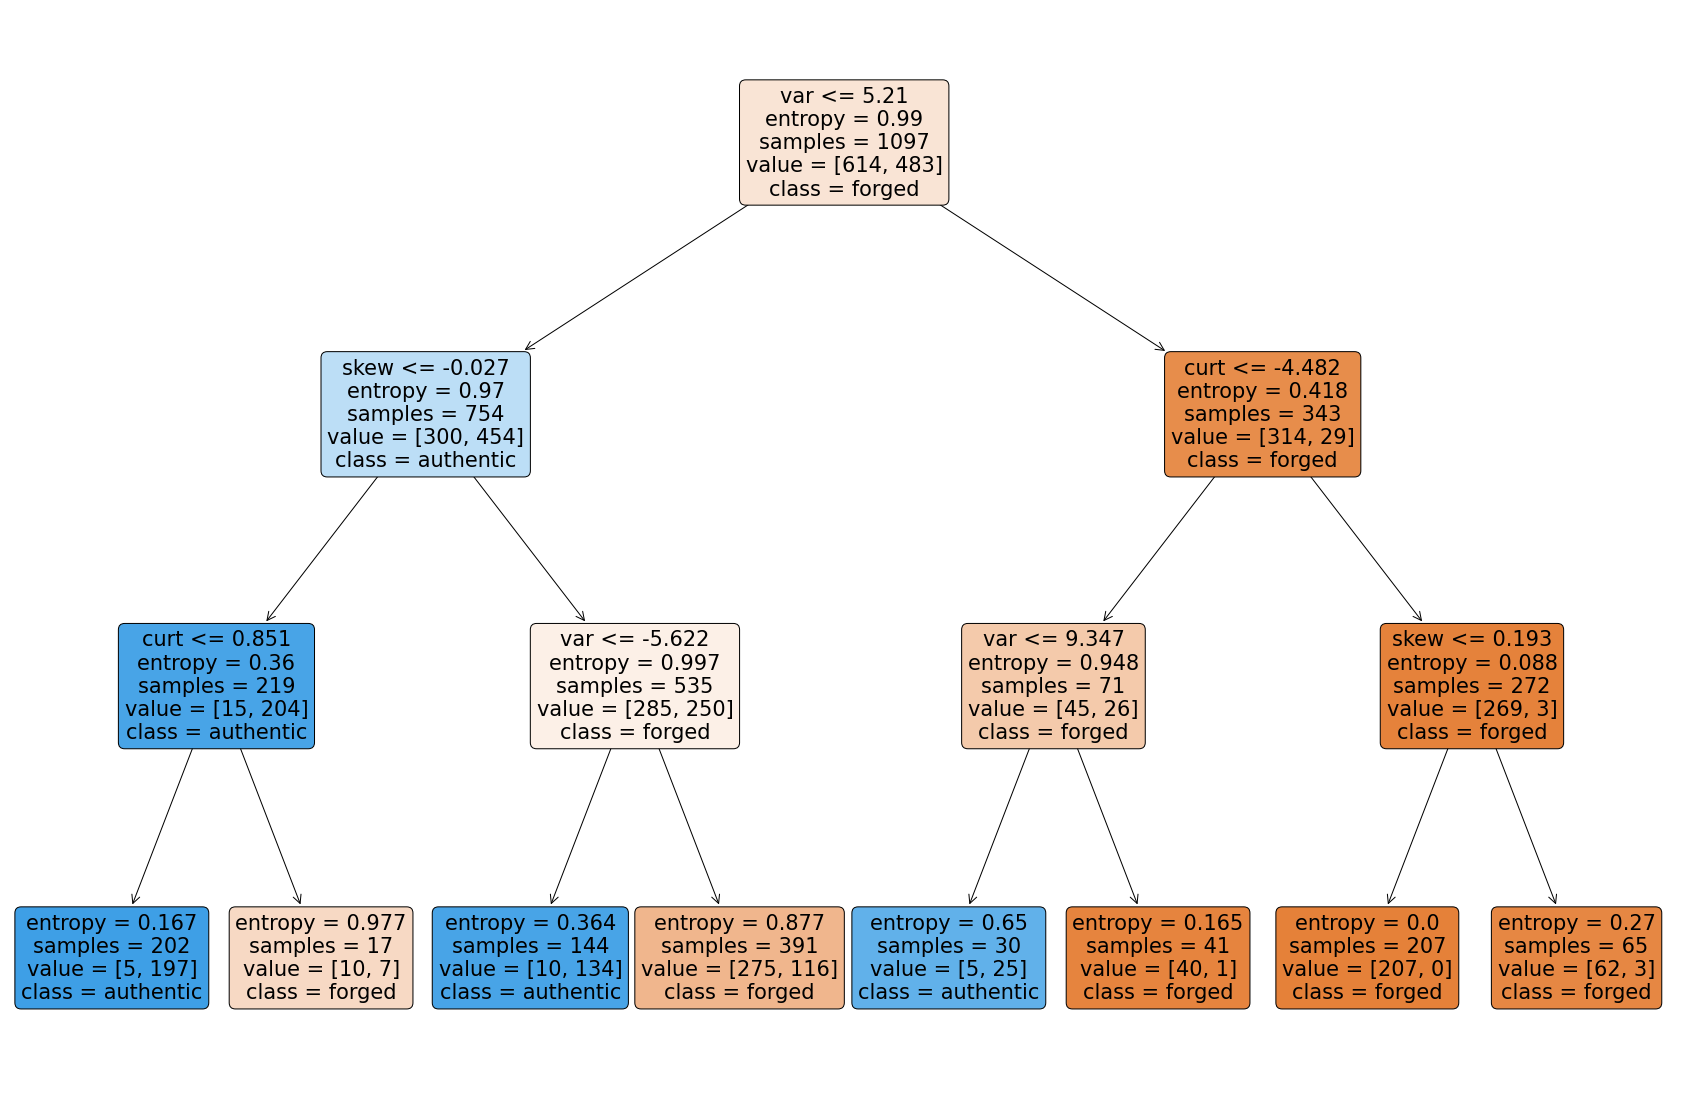

In [118]:
plotTree(clf)

In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="gini", max_depth=3, min_samples_split=10)

# Train Decision Tree Classifer
clf = clf.fit(X_2_train,Y_2_train)

#Predict the response for test dataset
Y_2_pred = clf.predict(X_2_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy_score(Y_2_test, Y_2_pred))

Accuracy: 0.8327272727272728


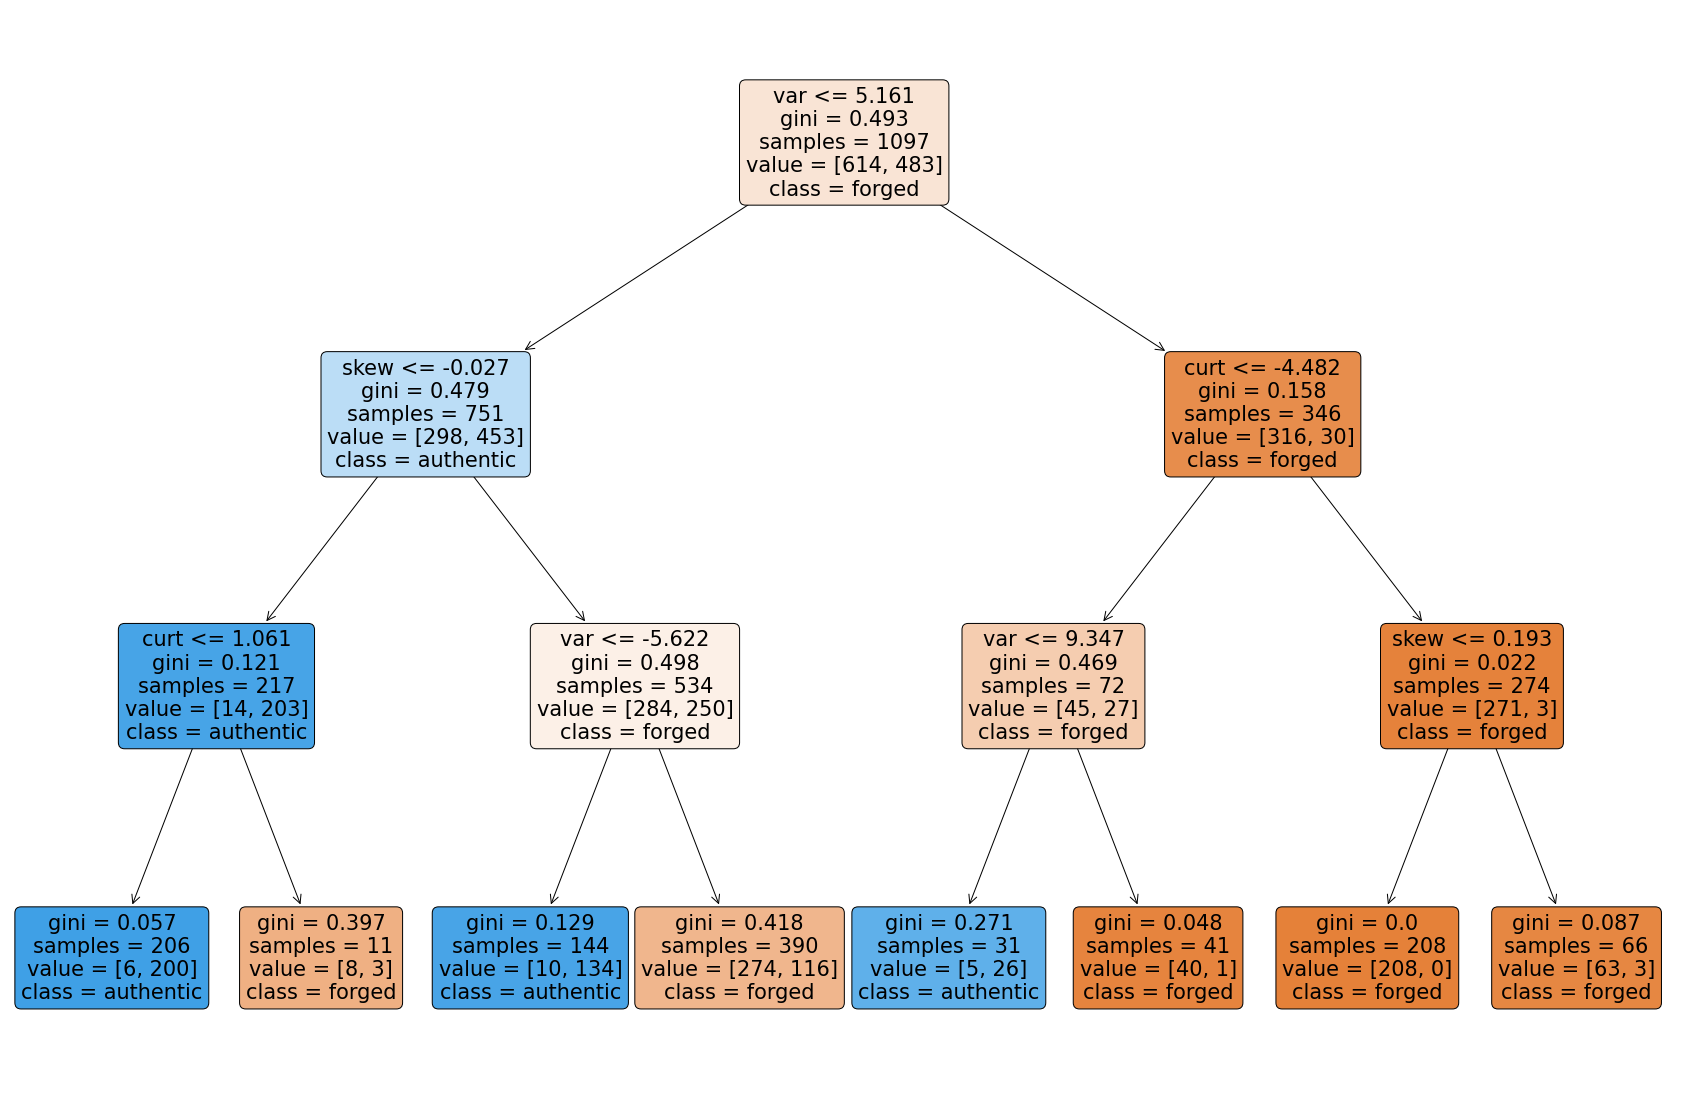

In [120]:
plotTree(clf)

In [121]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_split=23)

# Train Decision Tree Classifer
clf = clf.fit(X_2_train,Y_2_train)

#Predict the response for test dataset
Y_2_pred = clf.predict(X_2_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy_score(Y_2_test, Y_2_pred))

Accuracy: 0.8363636363636363


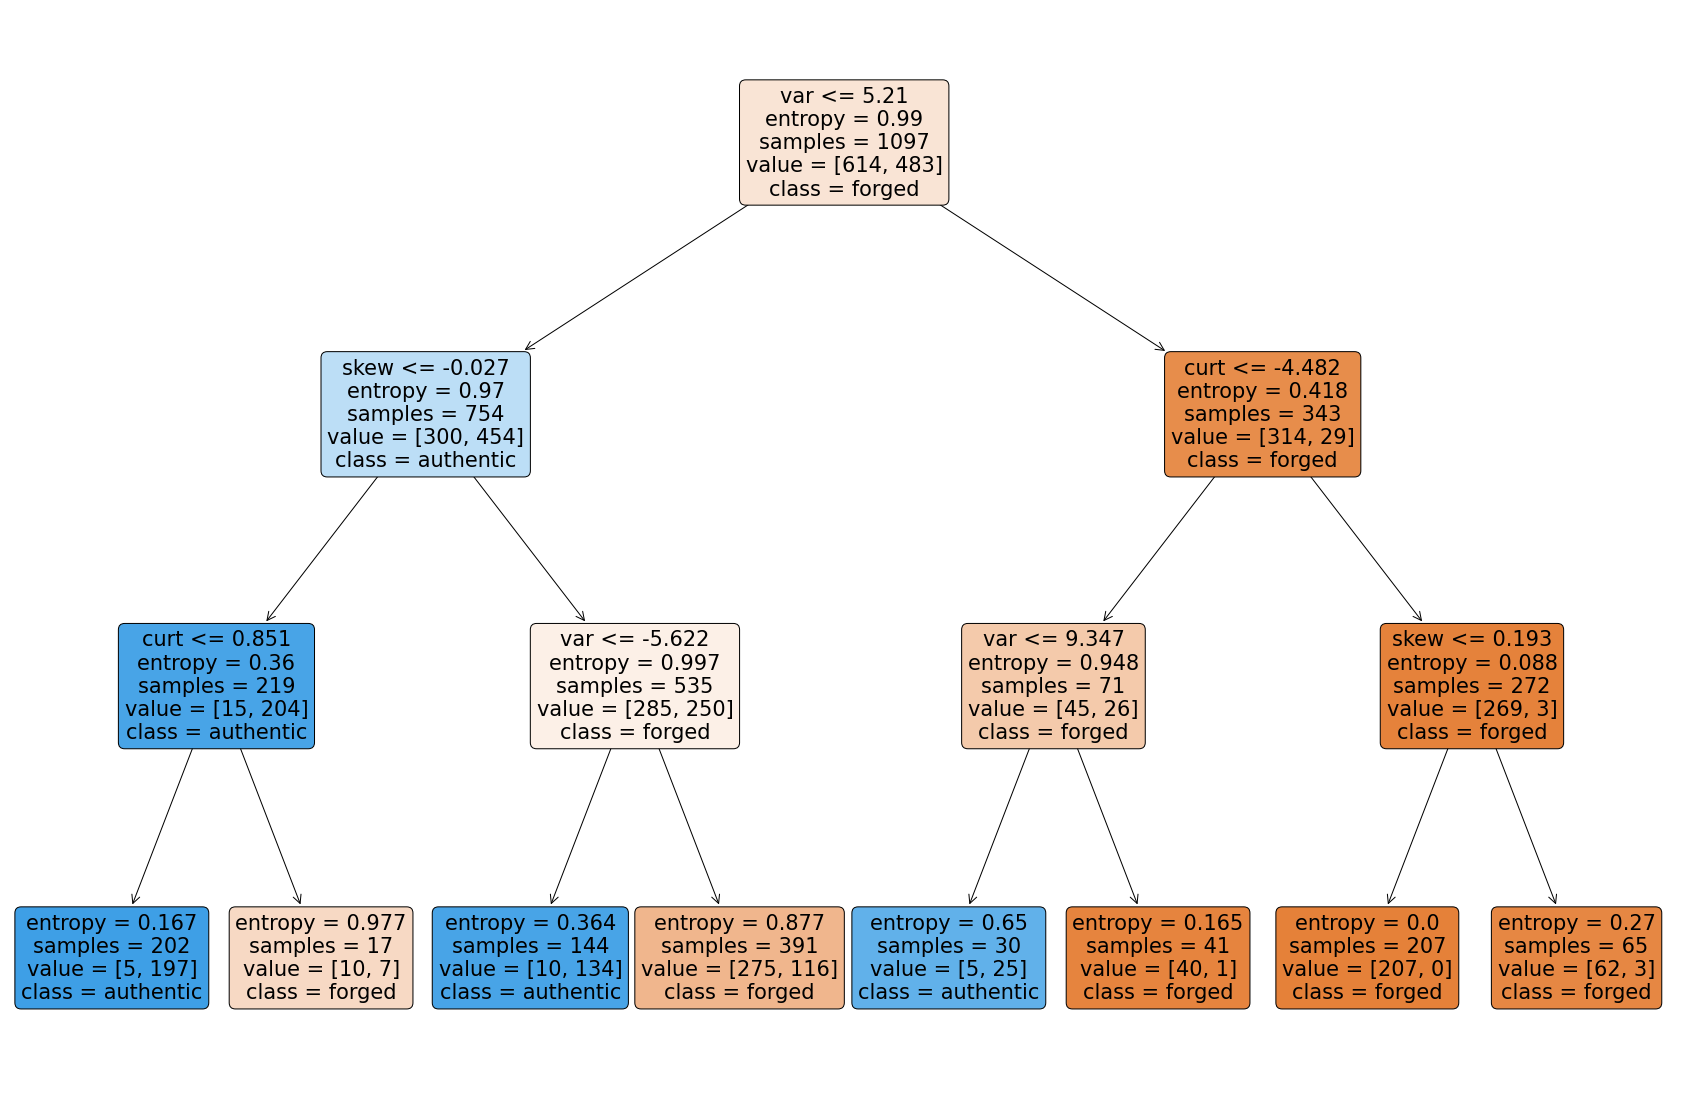

In [122]:
plotTree(clf)

In [123]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="gini", max_depth=3, min_samples_split=35)

# Train Decision Tree Classifer
clf = clf.fit(X_2_train,Y_2_train)

#Predict the response for test dataset
Y_2_pred = clf.predict(X_2_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy_score(Y_2_test, Y_2_pred))

Accuracy: 0.8327272727272728


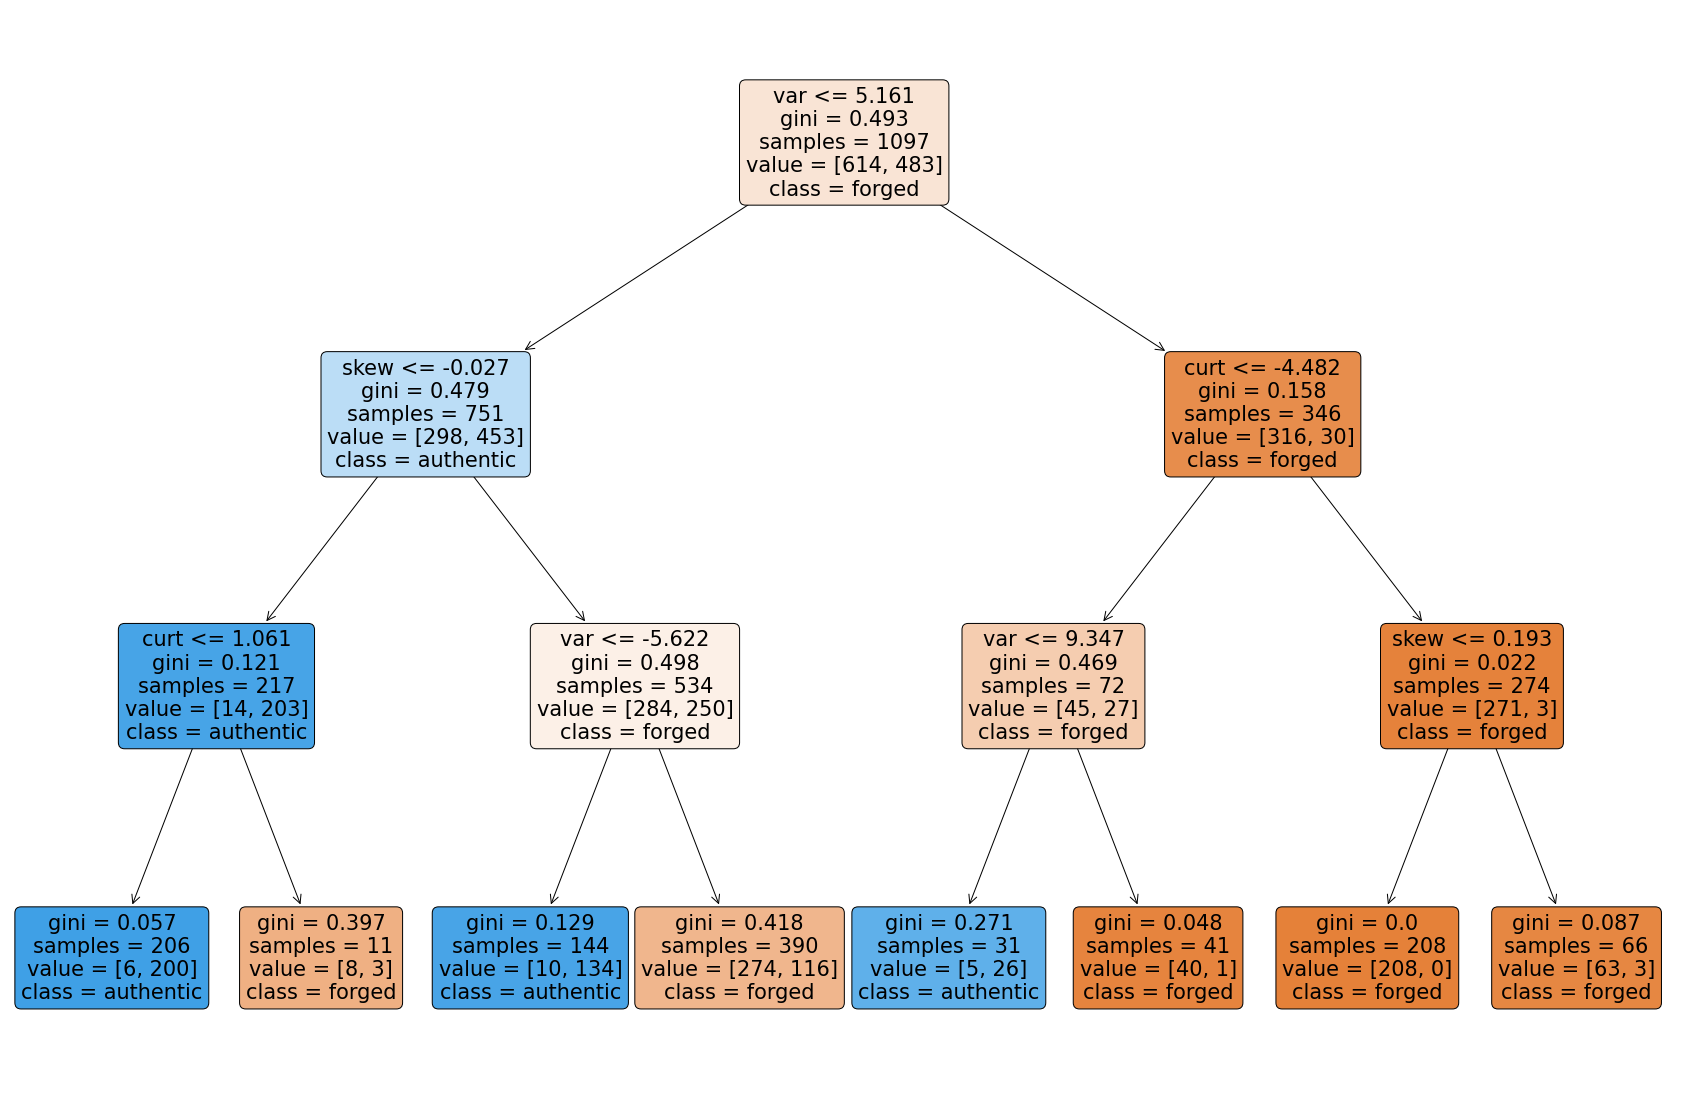

In [124]:
plotTree(clf)

In [125]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=6, min_samples_split=20)

# Train Decision Tree Classifer
clf = clf.fit(X_2_train,Y_2_train)

#Predict the response for test dataset
Y_2_pred = clf.predict(X_2_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy_score(Y_2_test, Y_2_pred))

Accuracy: 0.9054545454545454


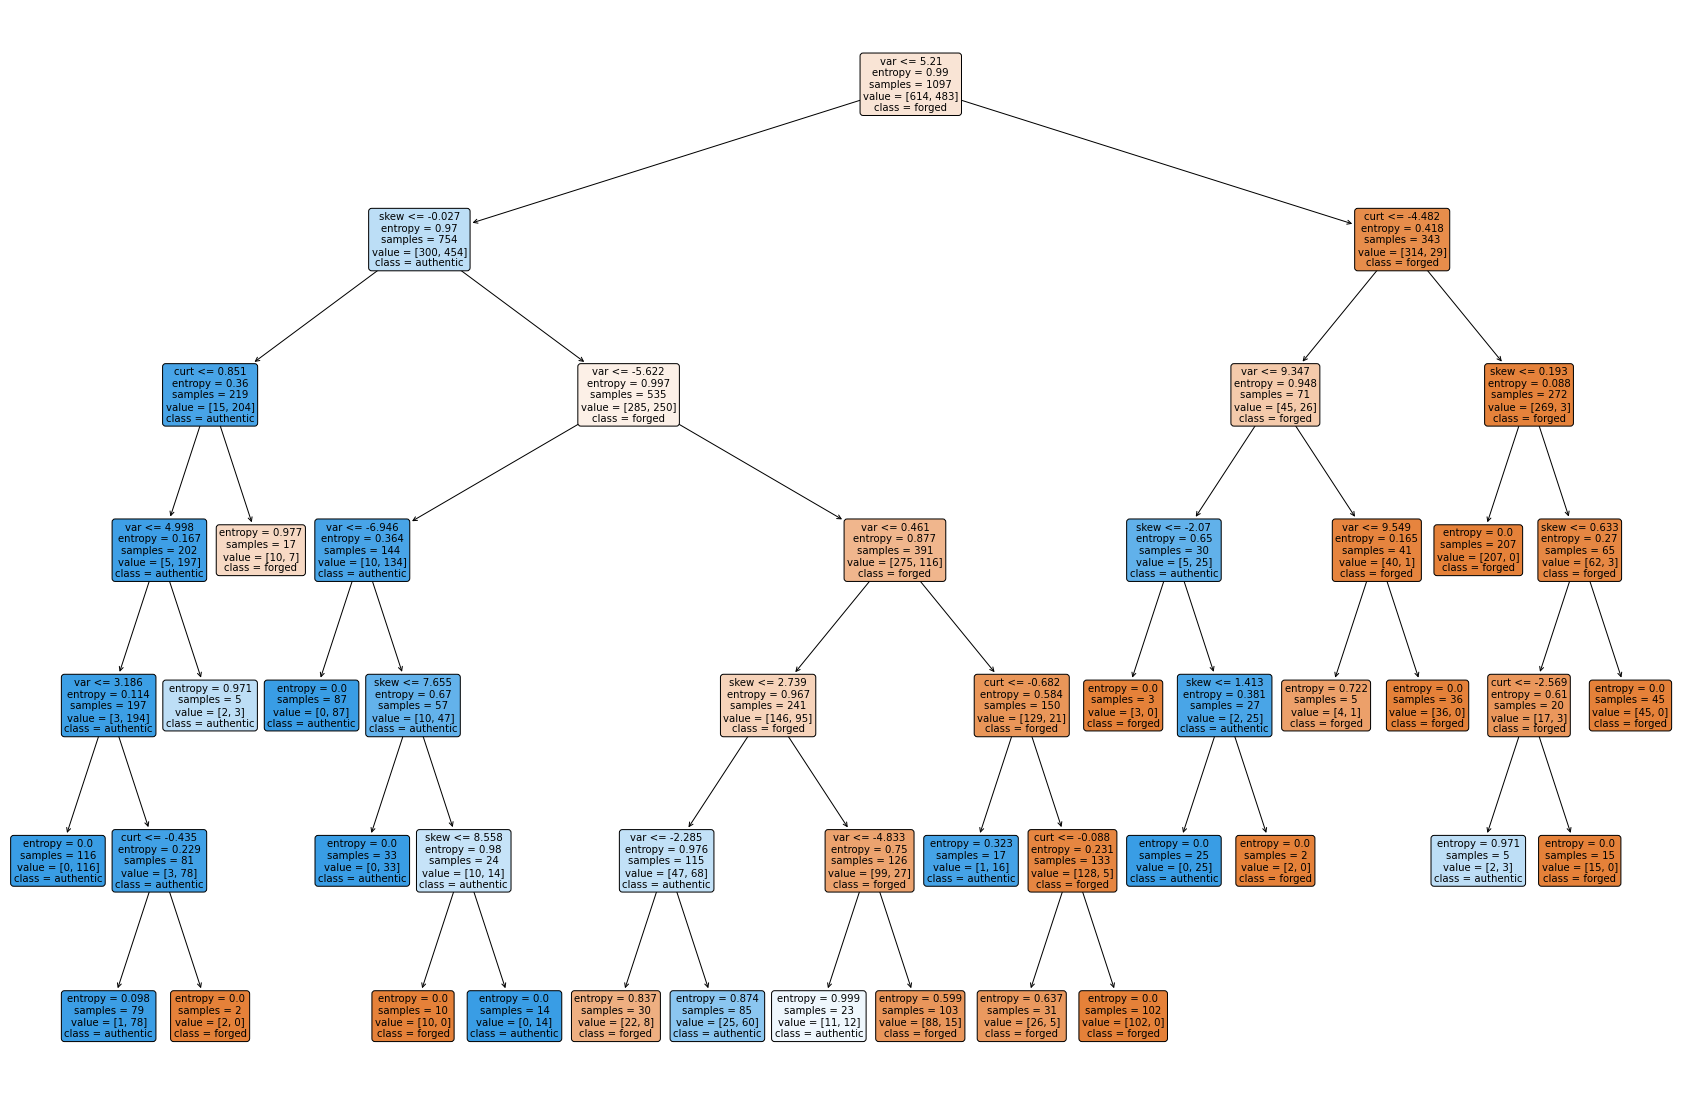

In [126]:
plotTree(clf)

In [127]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="gini", max_depth=6, min_samples_split=20)

# Train Decision Tree Classifer
clf = clf.fit(X_2_train,Y_2_train)

#Predict the response for test dataset
Y_2_pred = clf.predict(X_2_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy_score(Y_2_test, Y_2_pred))

Accuracy: 0.9054545454545454


In [128]:
plotTree(clf)

### Denouement

Use this place to report all comparisons and wrap up the calls to the functions written above.

| Criterion | MaxDepth | Min. Samples Split | Accuracy |
| --- | --- | --- | --- |
| Entropy | 3 | 10 | 83.6% |
| Gini | 3 | 10 | 83.2% |
| Entropy | 3 | 23 | 0.836% |
| Gini | 3 | 35 | 83.2% |
| Entropy | 6 | 20 | 90.5% |
| Gini | 6 | 20 | 90.5% |

***Rough below***

<!-- | Criterion | MaxDepth | Min. Samples Split | Accuracy |
| --- | --- | --- | --- |
| Entropy | 3 | 2 < x < 22 | 92.36% |
| Gini | 3 | 2 < x < 35 | 93.8% |
| Entropy | 5 | 2 < x < 20 | 98.18% |
| Gini | 5 | 2 < x < 20 | 97.09% |
| Entropy | 3 | 23 | 91.27% |
| Gini | 3 | 36 | 92.7% | -->

In [129]:
# feature_cols = ["variance", "skewness", "curtosis"]

# from six import StringIO
# # from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus
# dot_data = StringIO()
# export_graphviz(clf, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True, feature_names = feature_cols,class_names=['0','1'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('bankAuth.png')
# Image(graph.create_png())